In [1]:
import sddk
import pandas as pd
import math
import statistics
import geopandas as gpd # https://vincent.doba.fr/posts/20210407_install-fiona-on-windows/ & https://geopandas.org/getting_started/install.html Issues with geopandas on windows. The requirements.txt file might be able to install the packages, if not you should look into these geopandas links.
import requests
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.stats import trapz
import scipy
#import nltk
import json
import tempun
import numpy as np
import re
from geopy.geocoders import Nominatim
import csv

## Exploring mounds used in multiple periods in time

The first code here is if one has the dataset locally on your computer as an excel-file.

In [2]:
#Mounds_all_sheets = pd.ExcelFile('../data/AORDataset.xlsx') #reading all the sheets into python.
#mounds_df = pd.read_excel(Mounds_all_sheets, "BurialAttributes")#to start off with i only need the time data.
#mounds_df = pd.read_excel(Mounds_all_sheets, "GeneralSpatial")

Now the following chuncks of code are for pulling the data from google-sheets directly. It follows the method described in:

https://www.analyticsvidhya.com/blog/2020/07/read-and-update-google-spreadsheets-with-python/

I would just point out that google has changed the way some of it works. Once one has finished step 8, the JSON file is not automatically downloaded. Insted one must open their new service account, and generate the keys.

In [3]:
import gspread
import pandas as pd
from oauth2client.service_account import ServiceAccountCredentials
import sddk
import getpass

In [4]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

#When setting up the google service account some a "key -file" was downloaded as a json.file, you need the path to
#this file, in my case the path is "../../Keys/Google_sheets_access.json"
creds = ServiceAccountCredentials.from_json_keyfile_name("../../Keys/Google_sheets_access.json", scope)

# authorize the clientsheet 
client = gspread.authorize(creds)
# get the instance of the Spreadsheet
sheet = client.open('AORDataset')

# get the third sheet of the Spreadsheet
sheet_instance = sheet.get_worksheet(2) #we are working with spreadsheet nr. 2

mounds_data = sheet_instance.get_all_records()

mounds_df = pd.DataFrame.from_dict(mounds_data)

I will start by looking into how many burial there are. 

In [5]:
len(mounds_df)

3063

I will start by cleaning the data. to be able to examine if a mound has been used in to seperate periods in time, the datapoints need to have been assigned some numerical data. I will examine if this is the case. 

In [104]:
#i will start checking the data, if there are datapoint with only an start point and no endpoint:
Mounds_no_enddate_index = [] 
for index in range(len(mounds_df)):
    if type(mounds_df["Enddate"][index]) != float:
        if type(mounds_df["Enddate"][index]) != int:
            Mounds_no_enddate_index.append(index)
    elif math.isnan(mounds_df["Enddate"][index]):
        Mounds_no_enddate_index.append(index)
Mounds_no_enddate_index

[119,
 253,
 376,
 377,
 726,
 742,
 744,
 746,
 779,
 838,
 876,
 877,
 889,
 890,
 892,
 893,
 894,
 895,
 896,
 898,
 990,
 991,
 1325,
 1359,
 1360,
 1361,
 1364,
 1365,
 1366,
 1367,
 1368,
 1369,
 1377,
 1378,
 1379,
 1380,
 1381,
 1382,
 1383,
 1384,
 1385,
 1386,
 1387,
 1388,
 1389,
 1390,
 1391,
 1392,
 1393,
 1486,
 1490,
 1546,
 1548,
 1549,
 1550,
 1551,
 1745,
 1746,
 1766,
 1842,
 1878,
 1880,
 1959,
 1960,
 1964,
 1965,
 1966,
 1992,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2007,
 2008,
 2013,
 2014,
 2015,
 2210,
 2211,
 2213,
 2248,
 2249,
 2250,
 2251,
 2252,
 2259,
 2260,
 2261,
 2262,
 2263,
 2277,
 2278,
 2279,
 2281,
 2296,
 2635,
 2999,
 3000,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014]

I will do the same for startingdates

In [105]:
Mounds_no_startdate_index = [] 
for index in range(len(mounds_df)):
    if type(mounds_df["StartDate"][index]) != float:
        if type(mounds_df["StartDate"][index]) != int:
            Mounds_no_startdate_index.append(index)
    elif math.isnan(mounds_df["StartDate"][index]):
        Mounds_no_startdate_index.append(index)
Mounds_no_startdate_index

[119,
 253,
 726,
 742,
 744,
 746,
 779,
 838,
 889,
 890,
 892,
 893,
 894,
 895,
 896,
 898,
 990,
 991,
 1325,
 1359,
 1360,
 1361,
 1364,
 1365,
 1366,
 1367,
 1368,
 1369,
 1377,
 1378,
 1379,
 1380,
 1381,
 1382,
 1383,
 1384,
 1385,
 1386,
 1387,
 1388,
 1389,
 1390,
 1391,
 1392,
 1393,
 1486,
 1490,
 1546,
 1548,
 1549,
 1550,
 1551,
 1745,
 1746,
 1766,
 1842,
 1878,
 1880,
 1959,
 1960,
 1964,
 1965,
 1966,
 1992,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2007,
 2008,
 2013,
 2014,
 2015,
 2210,
 2211,
 2248,
 2249,
 2250,
 2251,
 2252,
 2259,
 2260,
 2261,
 2262,
 2263,
 2277,
 2278,
 2279,
 2281,
 2296,
 2635,
 2999,
 3000,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014]

I will shortly examine the datapoints with only an startpoint and endpoint:

In [106]:
Mounds_with_only_startdate_index = [index for index in Mounds_no_enddate_index
                                    if index not in Mounds_no_startdate_index]
Mounds_with_only_startdate_index

[376, 377, 876, 877, 2213]

In [107]:
Mounds_with_only_enddate_index = [index for index in Mounds_no_startdate_index
                                  if index not in Mounds_no_enddate_index]
Mounds_with_only_enddate_index

[]

From the above i can see that any datapoint missing an enddate, is also missing its startdate.
I can use this to extract the datapoints with no temporal data.

In [108]:
#I will quickly make a list of the index of datapoints with no end or startdate for later use
mounds_with_no_dates_index = list(set(Mounds_no_startdate_index).intersection(set(Mounds_no_enddate_index)))
len(mounds_with_no_dates_index)

110

 I will now look at the startdates of the burials with only a startdate:

In [109]:
mounds_df.loc[[376, 377, 876, 877, 2213]]

,MoundID,Name,GraveNo,Enclosure Type,LaborAssessment,Burial No,Extra skeletal remains?,Notes on burial,Assemblage?,AnimalRemains,...,FineVessels,DrinkingCups,Jewellery,Weapons,SpecialFinds,Imports,Grave Rank symbols,StartDate,Enddate,Chronology rating
376,1066,Mound 3,4,Funeral pyre in a pit,"some elaboration (marks of a coffin, small sto...",1,,,Y,2 glass vessels; 2 red slipped bowls;,...,,,1 golden ring with gem; 2 silver torques; 4 gl...,,14 applications and a chain from a wooden ches...,,2 - Several symbols of status across multiple ...,240,?,1 - rough estimate by author on basis of the a...
377,1066,Mound 3,5,Funeral pyre in a pit,"some elaboration (marks of a coffin, small sto...",1,,primary burial,Y,,...,"1 bowl, 1 plate",,,,3 bronze coins 200-217 AD,,"1 - One or two status symbols (ochre, personal...",217,?,1 - rough estimate by author on basis of the a...
876,1128,Mound 1,1,Cist grave,major elaboration (ashlar /cist /stone lined g...,,,No human remains are found,No archaeological artefacts are left after tom...,,...,,,,,,,not available,-350,?,1 - rough estimate by author on basis of the a...
877,1129,Mound 2,1,Tomb of brick or stone,major elaboration (ashlar /cist /stone lined g...,,,No human remains are found,No archaeological artefacts are left after tom...,,...,,,,,,,not available,-350,?,1 - rough estimate by author on basis of the a...
2213,1448,Mound 2,1,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,,secondary grabe,N,,...,,,,,,,0 - No symbols of status present,300,?,0 - no chronology


In [110]:
Mounds_with_only_startdate_df = mounds_df.loc[Mounds_with_only_startdate_index]
Mounds_with_only_startdate_df[["MoundID", "StartDate", "Enddate"]]

,MoundID,StartDate,Enddate
376,1066,240,?
377,1066,217,?
876,1128,-350,?
877,1129,-350,?
2213,1448,300,?


It seems that both datapoint 376 and 377 come from the same mound. I will shortly examine if any of the four mounds with a burial with only and endpoint come from the same mounds.

In [111]:
for moundID in Mounds_with_only_startdate_df["MoundID"]:
    print(len(mounds_df[mounds_df["MoundID"] == moundID]))

5
5
1
1
2


It seems that both mound 1066 and mound 1448 are interesting when we want to examine if the mounds have been used in diffrent periods, because they have multiple burials.

In [112]:
Mound_1066_df = mounds_df[mounds_df["MoundID"] == 1066]
Mound_1066_df[["MoundID", "StartDate", "Enddate"]]

,MoundID,StartDate,Enddate
373,1066,220,240
374,1066,220,240
375,1066,220,240
376,1066,240,?
377,1066,217,?


Looking at this, it seems that mound 1066 has only been used in one cultural historical periods.

In [113]:
Mound_1448_df = mounds_df[mounds_df["MoundID"] == 1448]
Mound_1448_df[["MoundID", "StartDate", "Enddate"]]

,MoundID,StartDate,Enddate
2213,1448,300,?
2214,1448,150,200


This on the other hand seems interesting i will quickly this will need to be added for later.

In [114]:
Mound_1448 = [1448, [[150, 200], [300, "?"]]]

## Examining the data for mounds used in different periods

For the following i only want the datapoints with both an start and end date. 

In [115]:
mounds_missing_date_information = list(set(Mounds_no_enddate_index + Mounds_no_startdate_index))
len(mounds_missing_date_information)

115

The above are then the datapoints with either a missing startdate, enddate or both.

In [116]:
Mounds_with_data_index = [index for index in range(len(mounds_df)) if index not in mounds_missing_date_information]
len(Mounds_with_data_index) #checking to see that indeed 13 elements have been removed. 

2948

I can now use this to make a subset of the of the dataframe where all datapoints have both a start and enddate. 

In [117]:
mounds_with_dates_df = mounds_df.loc[Mounds_with_data_index]
mounds_with_dates_df.head()

,MoundID,Name,GraveNo,Enclosure Type,LaborAssessment,Burial No,Extra skeletal remains?,Notes on burial,Assemblage?,AnimalRemains,...,FineVessels,DrinkingCups,Jewellery,Weapons,SpecialFinds,Imports,Grave Rank symbols,StartDate,Enddate,Chronology rating
0,1002,Mound 5,1,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,N,,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
1,1002,Mound 5,1,Simple pit,no elaboration (eg.a pit or no indistinct encl...,2,N,,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
2,1002,Mound 5,2,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,N,,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
3,1002,Mound 5,2,Simple pit,no elaboration (eg.a pit or no indistinct encl...,2,N,,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
4,1003,No name,1,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,N,Main Burial (earlier),Y,,...,,,2(silver spirals),,red ochre,,"1 - One or two status symbols (ochre, personal...",-3500,-3000,3 - a number of burial aspects consulted and c...


I will now look into if there are any mounds with more than one period of use.

I will start by grouping the mounds by their mound_id:

In [118]:
Mounds_with_data_index[119]

120

In [119]:
Mounds_by_id_dictionary = {} #this is a dictionary for storring the index of the datapoints related to each mounds
for index in Mounds_with_data_index:#if moundID is already in dictionary, just add the index to the key
    if mounds_with_dates_df["MoundID"][index] in Mounds_by_id_dictionary:
        Mounds_by_id_dictionary[mounds_with_dates_df["MoundID"][index]].append(index)
    else: #if not add the mound to the ditionary. 
        Mounds_by_id_dictionary[mounds_with_dates_df["MoundID"][index]] = [index]
len(Mounds_by_id_dictionary) #How many different mounds are there?

481

Clearly the mounds that have only have a single burial dont need to be looked at when examining mounds used multiple times. 

In [120]:
Mounds_used_multiple_times = {}
for mound in Mounds_by_id_dictionary:
    if len(Mounds_by_id_dictionary[mound]) > 1:
        Mounds_used_multiple_times[mound] = Mounds_by_id_dictionary[mound]
len(Mounds_used_multiple_times) #How many of the mounds were used multiple times.

259

The question is now how to define that a burial mound has been used in different timeperiods? There are a few different problems here.

One could say that a burial mound has been used in two different periods, if the mound countains two different burials, where the latest date of an earlier burial is separated by the latest date of the other burial by some threshold, lets say 100 years?

One could also deside the say that it has been used in different periods, if it has been used in different cultural timeperiods. 

In the following i have desided that a mound that has been used in two different timeperiods must contain at least two non-overlaping burials, as if this wasn't the case, all the burials might still have happened at the same time.

To allow the user to decide the threshold i am introducing a variable mounds_threshold that can be changed. 

In [121]:
# Add a thing where you can set your own threeshold.

In [122]:
mounds_threshold = 0 # I have set the mounds_threshold to a default value 0
Mounds_with_separated_burials = {}
for mound in Mounds_used_multiple_times:
    mound_multiple_df = mounds_df.loc[Mounds_used_multiple_times[mound]] #creating af subset-dataframe of the burials relatied to a specific mound
    for latest in mound_multiple_df["Enddate"]:
        for earliest in mound_multiple_df["StartDate"]:
            if mounds_threshold < earliest - latest:
                Mounds_with_separated_burials[mound] = Mounds_used_multiple_times[mound]
                break
        break
len(Mounds_with_separated_burials) #how many are there.

50

I would now like to look at the differnet burrial patterns in the different mounds. 

In [123]:
Mounds_different_intervals = {} 
for mound in Mounds_with_separated_burials:
    List_of_destinct_intervals = []
    for index in Mounds_with_separated_burials[mound]:
        List_of_destinct_intervals.append([mounds_with_dates_df["StartDate"][index],
                                           mounds_with_dates_df["Enddate"][index]])
    Mounds_different_intervals[mound] = List_of_destinct_intervals
Mounds_different_intervals

{1054: [[-2000, -1600],
  [-2000, -1600],
  [-400, -300],
  [-2000, -1800],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000]],
 1062: [[100, 300], [100, 300], [100, 300], [1400, 1800], [1400, 1800]],
 1068: [[-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-1600, -1100],
  [-1600, -1100],
  [-1600, -1100],
  [1000, 1400]],
 1070: [[-3000, -2000],
  [-3000, -2000],
  [1000, 1400],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000],
  [-3000, -2000]],
 1074: [[-300, -200], [1300, 1400]],
 1080: [[200, 400],
  [200, 400],
  [200, 400],
  [200, 400],
  [200, 400],
  [200, 400],
  [900, 120

Clearly some of these intervals are dublicates, i will quickly clean these away.

In [124]:
#Cleaning the dublicates, so we only have one of each distinct interval. 
Mounds_destinct_intervals = {}
for mound in Mounds_different_intervals:
    list_of_distinct = []
    for interval in Mounds_different_intervals[mound]:
        if interval not in list_of_distinct:
            list_of_distinct.append(interval)
    Mounds_destinct_intervals[mound] = list_of_distinct
Mounds_destinct_intervals

{1054: [[-2000, -1600], [-400, -300], [-2000, -1800], [-3000, -2000]],
 1062: [[100, 300], [1400, 1800]],
 1068: [[-3000, -2000], [-1600, -1100], [1000, 1400]],
 1070: [[-3000, -2000], [1000, 1400]],
 1074: [[-300, -200], [1300, 1400]],
 1080: [[200, 400], [900, 1200]],
 1109: [[-1900, -1700],
  [-400, -350],
  [-3200, -2800],
  [-3200, -2200],
  [-2500, -2200]],
 1138: [[-425, -375], [350, 400], [1000, 1400]],
 1152: [[-400, -350], [75, 125]],
 1170: [[-1500, -1200], [200, 350]],
 1172: [[-1500, -1200], [-1500, -1350], [300, 400]],
 1175: [[-200, -50], [350, 425]],
 1191: [[-1300, -1150], [-3000, -2500], [-400, -350], [-600, -500]],
 1195: [[150, 200], [200, 300], [1000, 1200]],
 1200: [[-500, -400], [900, 1700]],
 1201: [[-400, -350], [300, 400], [400, 600]],
 1211: [[-400, -350], [1877, 1878]],
 1225: [[-1300, -1200], [-425, -375], [-625, -500], [-350, -325]],
 1226: [[-1300, -1200], [1800, 1900]],
 1233: [[-350, -300], [1775, 1825], [-2500, -2100], [-2100, -1800]],
 1279: [[325, 42

Is is interesting here that one of the of the datapoints is (nan, nan), i will clean this away, aswell fixing the problems with the mounds where the dates have been sorted wrongly.

In [125]:
for mound in Mounds_destinct_intervals:
    for interval in Mounds_destinct_intervals[mound]:
        start, end = interval
        if math.isnan(start):
             Mounds_destinct_intervals[mound].remove(interval)
print(len(Mounds_destinct_intervals))
Mounds_destinct_intervals

50


{1054: [[-2000, -1600], [-400, -300], [-2000, -1800], [-3000, -2000]],
 1062: [[100, 300], [1400, 1800]],
 1068: [[-3000, -2000], [-1600, -1100], [1000, 1400]],
 1070: [[-3000, -2000], [1000, 1400]],
 1074: [[-300, -200], [1300, 1400]],
 1080: [[200, 400], [900, 1200]],
 1109: [[-1900, -1700],
  [-400, -350],
  [-3200, -2800],
  [-3200, -2200],
  [-2500, -2200]],
 1138: [[-425, -375], [350, 400], [1000, 1400]],
 1152: [[-400, -350], [75, 125]],
 1170: [[-1500, -1200], [200, 350]],
 1172: [[-1500, -1200], [-1500, -1350], [300, 400]],
 1175: [[-200, -50], [350, 425]],
 1191: [[-1300, -1150], [-3000, -2500], [-400, -350], [-600, -500]],
 1195: [[150, 200], [200, 300], [1000, 1200]],
 1200: [[-500, -400], [900, 1700]],
 1201: [[-400, -350], [300, 400], [400, 600]],
 1211: [[-400, -350], [1877, 1878]],
 1225: [[-1300, -1200], [-425, -375], [-625, -500], [-350, -325]],
 1226: [[-1300, -1200], [1800, 1900]],
 1233: [[-350, -300], [1775, 1825], [-2500, -2100], [-2100, -1800]],
 1279: [[325, 42

I have now created a dictionary containing i each mounds used in at least two non-overlapping time-intervals.

## Different cultural periods

In the following i will look into assigning the different mounds into different cultural periods. 

I will start by looking at the mounds used in multiple periods.

I will start by doing a scatterplot over time, to find the historical periods of significance. For this i will assign each burial the mean of it's start and enddate. 

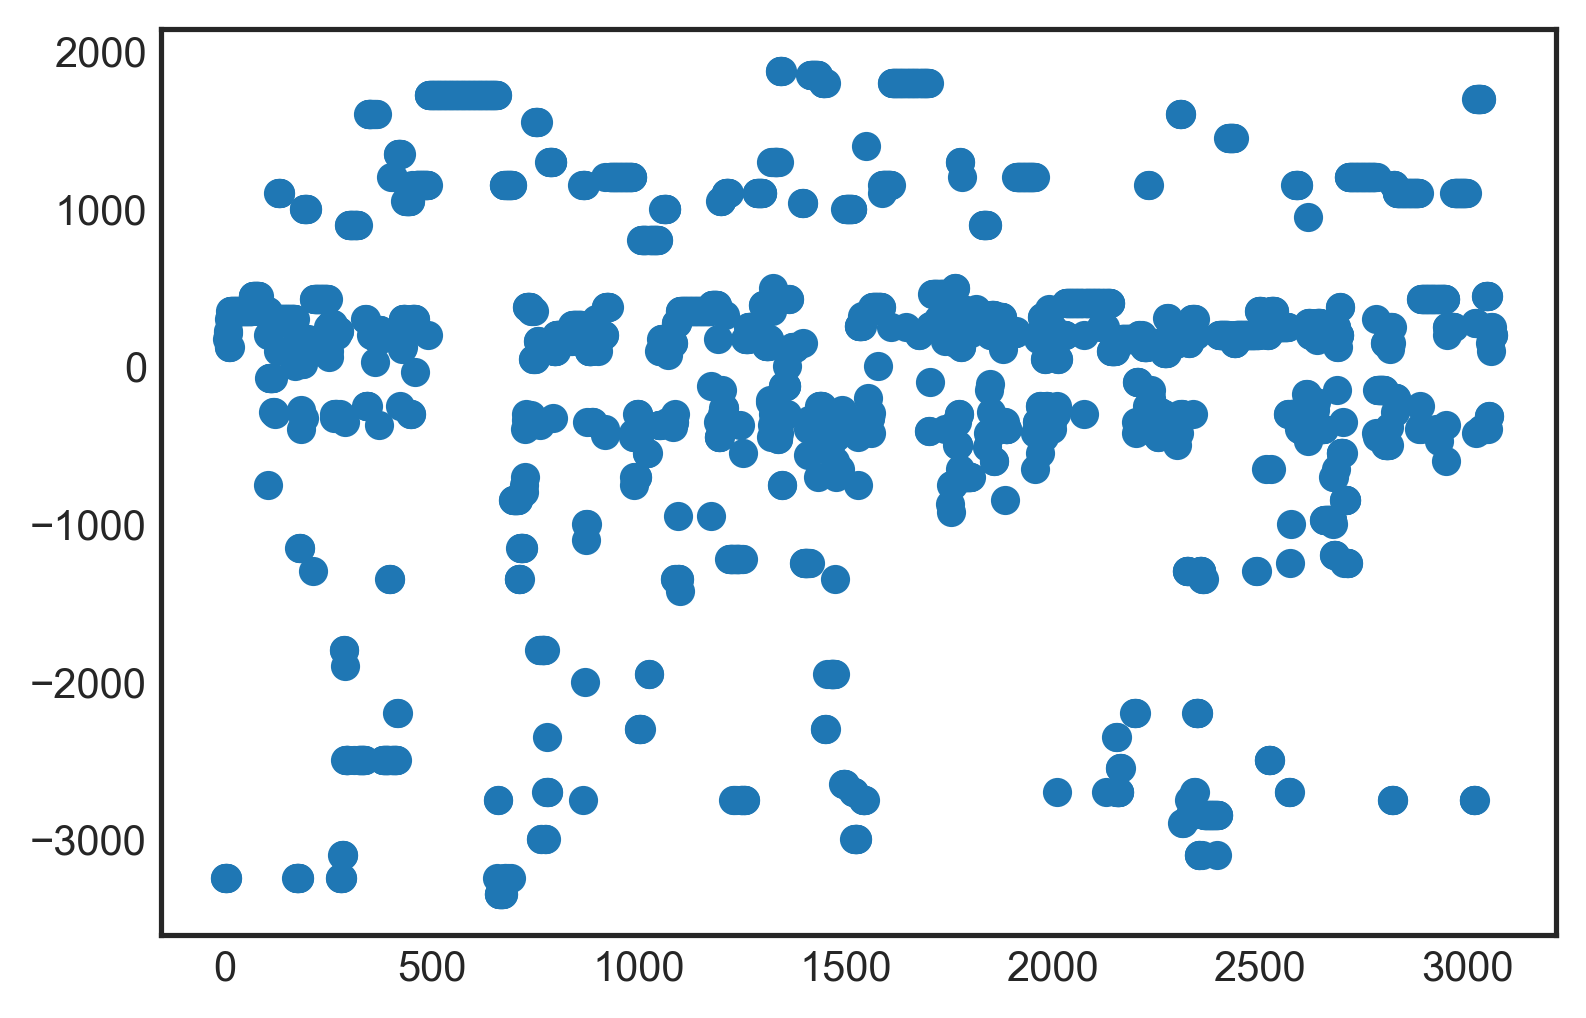

In [126]:
startdates = mounds_with_dates_df["StartDate"]
enddates = mounds_with_dates_df["Enddate"]
date = [(startdates[index] + enddates[index])/2 for index in Mounds_with_data_index ]
plt.scatter(Mounds_with_data_index, date)

I will also do a quick scatterplot of the first usage of each mound. 

For this i will use each mounds first date.

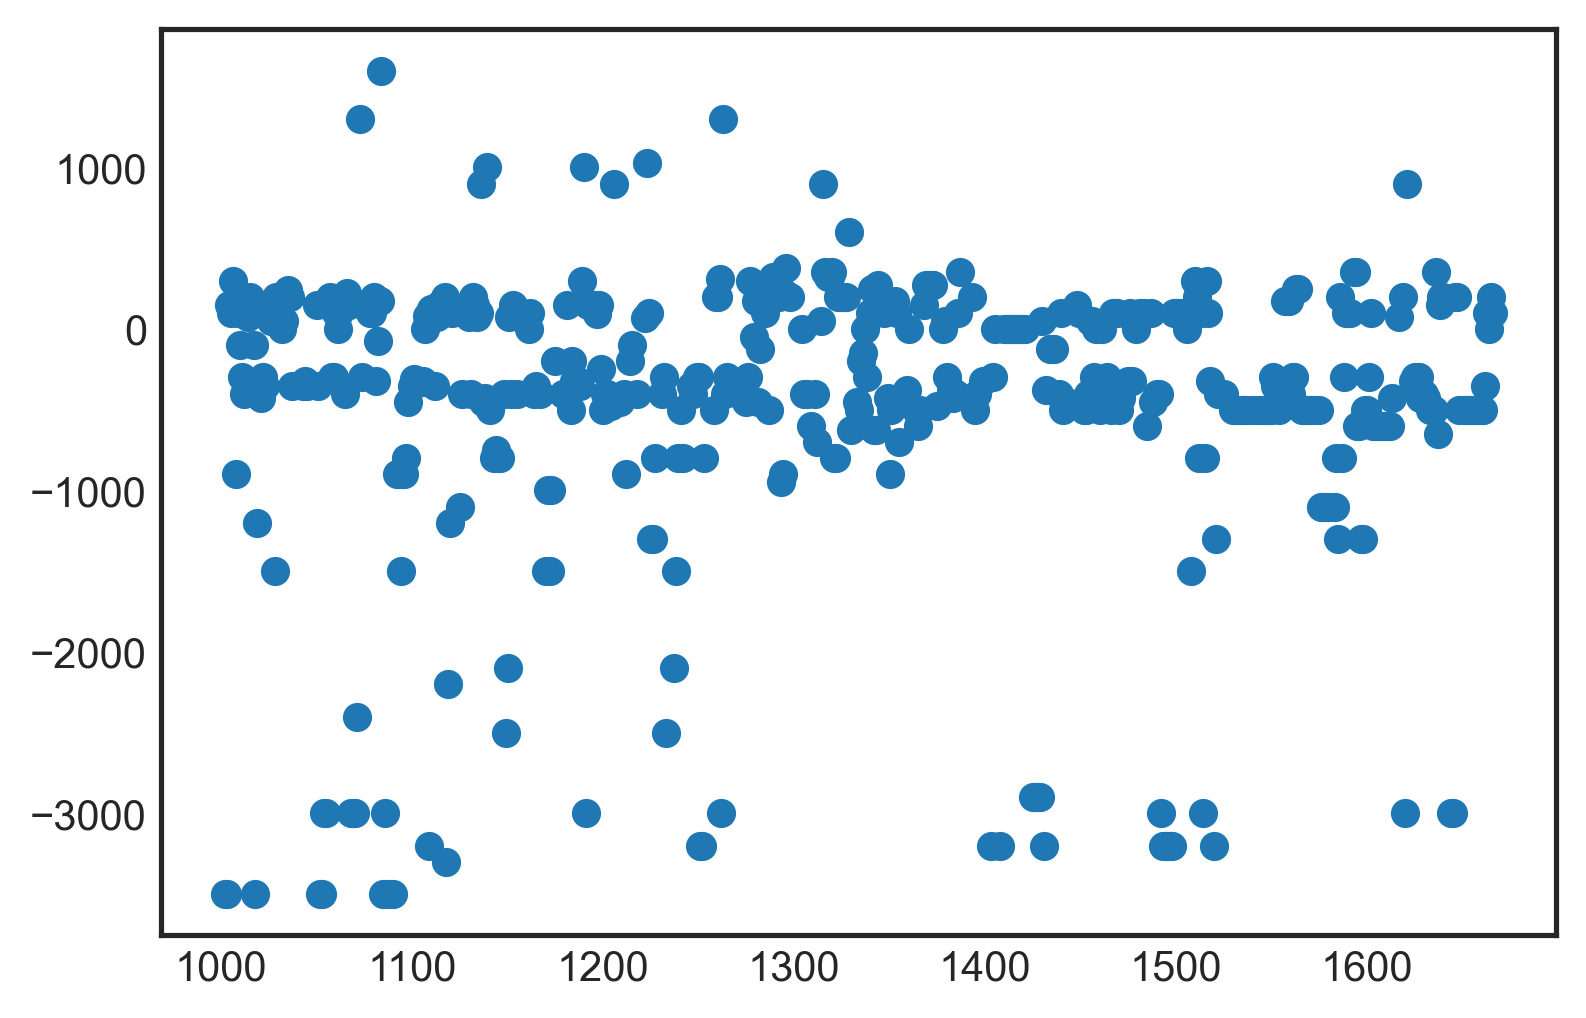

In [127]:
Mounds_by_id_dictionary
mounds = [mound for mound in Mounds_by_id_dictionary]
Mounds_with_first_use = []
for mound in Mounds_by_id_dictionary:
    Mound_min = 10000
    for burial in Mounds_by_id_dictionary[mound]:
        if mounds_with_dates_df["StartDate"][burial] <= Mound_min:
            Mound_min = mounds_with_dates_df["StartDate"][burial]
    Mounds_with_first_use.append(Mound_min)
plt.scatter(mounds, Mounds_with_first_use)

I it interesting here, that even though ther are quite a few burials after the year 1000, very few of these are on "new" mounds. 

I will now add some cultural periods, for assigning the periods. 

In the following i have changed combined early iron age 1 and 2, aswell as classical and hellenistic, and roman.

In [128]:
Periods = {"Transitional period":[-3900, -3200],
           "Early Bronze Age": [-3200, -2000], 
           "Middle Bronze age": [-2000, -1600], 
           "Late Bronze Age": [-1600, -1100], 
           "Early Iron Age": [-1100, -500], 
           "Classical and Hellenistic": [-500, -70], 
           "Roman period": [-70, 400], 
           "Late antiquity": [400, 600],
           "Early Byzantine": [600, 700],
           "First Bulgarian Kingdom": [700, 1000],
           "Middle Byzantine": [1000, 1200],
           "Second Bulgarian Kingdom": [1200, 1400],
           "Ottoman period": [1400, 1878],
           "Modern Bulgarian State": [1878, 2022]}
Period_enddate = [Periods[period][1] for period in Periods]
Period_enddate

[-3200,
 -2000,
 -1600,
 -1100,
 -500,
 -70,
 400,
 600,
 700,
 1000,
 1200,
 1400,
 1878,
 2022]

I will start by looking at the data, to see how many of the mounds used multiple times were used in periods overlapping different cultural periods.

The burial is problematic beacuse it is over different cultural periods. 

In [129]:
mounds_peroblem = [] #a list for storring the mounds with an interval that does not fit the cultural timeperiods.
for mound in Mounds_destinct_intervals:
    for interval in Mounds_destinct_intervals[mound]:
        start, end = interval
        for period in Periods:
            period_start, period_end = Periods[period]
            if period_start <= start and start < period_end:
                if end > period_end:
                    mounds_peroblem.append(mound)
mounds_peroblem

[1068,
 1070,
 1080,
 1138,
 1175,
 1175,
 1200,
 1226,
 1233,
 1279,
 1279,
 1280,
 1312,
 1354,
 1431,
 1458,
 1525,
 1554,
 1633,
 1634,
 1635]

So there are only four mounds with time intervals, where the interval overlaps different cultural periods. I will have a look at these datapoints.

In [130]:
mound_problem_df = mounds_df [[mound_id in mounds_peroblem for mound_id in mounds_df["MoundID"]]]
mound_problem_df

,MoundID,Name,GraveNo,Enclosure Type,LaborAssessment,Burial No,Extra skeletal remains?,Notes on burial,Assemblage?,AnimalRemains,...,FineVessels,DrinkingCups,Jewellery,Weapons,SpecialFinds,Imports,Grave Rank symbols,StartDate,Enddate,Chronology rating
381,1068,Mound 1,1,Simple pit,"some elaboration (marks of a coffin, small sto...",1,Y,Primary burial,N,,...,,,,,ochre,,0 - No symbols of status present,-3000,-2000,1 - rough estimate by author on basis of the a...
382,1068,Mound 1,1,Simple pit,"some elaboration (marks of a coffin, small sto...",2,Y,,N,,...,,,,,ochre,,0 - No symbols of status present,-3000,-2000,1 - rough estimate by author on basis of the a...
383,1068,Mound 1,1,Simple pit,"some elaboration (marks of a coffin, small sto...",3,Y,,N,,...,,,,,ochre,,0 - No symbols of status present,-3000,-2000,1 - rough estimate by author on basis of the a...
384,1068,Mound 1,2,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,,,N,,...,,,,,ochre,,0 - No symbols of status present,-3000,-2000,1 - rough estimate by author on basis of the a...
385,1068,Mound 1,3,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,,,Y,,...,,,2 silver pendant,,ochre,,"1 - One or two status symbols (ochre, personal...",-3000,-2000,1 - rough estimate by author on basis of the a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,1635,Mound 17,10,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,,,N,,...,,,,,,,0 - No symbols of status present,350,500,1 - rough estimate by author on basis of the a...
2941,1635,Mound 17,11,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,,,N,,...,,,,,,,0 - No symbols of status present,350,500,1 - rough estimate by author on basis of the a...
2942,1635,Mound 17,12,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,,,N,,...,,,,,,,0 - No symbols of status present,350,500,1 - rough estimate by author on basis of the a...
2943,1635,Mound 17,13,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,,,N,,...,,,,,,,0 - No symbols of status present,350,500,1 - rough estimate by author on basis of the a...


The quistion is now what period to assign these observations to. If i look at mount 1648, the problem is that multiple of the obervations have been dated between 1600 and 1800. Should these then be assigned as "midiaeval" of "modern"?. In the following i will assign these datapoints, as the period they overlap the most.!

In [131]:
Mounds_with_periods = {mound:[] for mound in Mounds_destinct_intervals}
for mound in Mounds_destinct_intervals:
    for interval[0], interval[1] in Mounds_destinct_intervals[mound]:
        mean = statistics.mean([interval[0], interval[1]])
        for period in Periods:
            start, end = Periods[period]
            if start <= mean and mean < end:
                if period not in Mounds_with_periods[mound]:
                    Mounds_with_periods[mound].append(period)
Mounds_with_periods

{1054: ['Middle Bronze age', 'Classical and Hellenistic', 'Early Bronze Age'],
 1062: ['Roman period', 'Ottoman period'],
 1068: ['Early Bronze Age', 'Late Bronze Age', 'Second Bulgarian Kingdom'],
 1070: ['Early Bronze Age', 'Second Bulgarian Kingdom'],
 1074: ['Classical and Hellenistic', 'Second Bulgarian Kingdom'],
 1080: ['Roman period', 'Middle Byzantine'],
 1109: ['Middle Bronze age', 'Classical and Hellenistic', 'Early Bronze Age'],
 1138: ['Classical and Hellenistic',
  'Roman period',
  'Second Bulgarian Kingdom'],
 1152: ['Classical and Hellenistic', 'Roman period'],
 1170: ['Late Bronze Age', 'Roman period'],
 1172: ['Late Bronze Age', 'Roman period'],
 1175: ['Classical and Hellenistic', 'Roman period'],
 1191: ['Late Bronze Age',
  'Early Bronze Age',
  'Classical and Hellenistic',
  'Early Iron Age'],
 1195: ['Roman period', 'Middle Byzantine'],
 1200: ['Classical and Hellenistic', 'Second Bulgarian Kingdom'],
 1201: ['Classical and Hellenistic', 'Roman period', 'Late an

I will now assign all burials a period. When datapoints have both a start and an enddate, i have decided that it will be the mean of the two, that decides which period the burial will be assigned to. 
If the burial only has one date, it will be assgined the period corresponding to that one date.
Else it will be assigned the period "Unkown".

Aswell as assigning each burial an individual period, the following code creates a list for each burial, containing all the periods that a specific burial overlaps with. 

In [132]:
Period = [0 for index in range(len(mounds_df))] #a list i can store the period in. 
All_periods = []
for index in range(len(mounds_df)):
    if index in Mounds_with_only_startdate_index: #assigning datapoint with only startdate
        mean = mounds_df["StartDate"][index]
        for period in Periods:
            start, end = Periods[period]
            if start <= mean and mean < end:
                Period[index] = period
                index_periods = []
                index_periods.append(period)
        #All_periods.append(index_periods)
    elif index in Mounds_with_only_enddate_index: #in this dataset there are no point with only enddate, but good to have
        mean = mounds_df["Enddate"][index]
        for period in Periods:
            start, end = Periods[period]
            if start < mean and mean <= end:
                Period[index] = period
                index_periods = []
                index_periods.append(period)
        #All_periods.append(index_periods)
    elif index in mounds_with_no_dates_index: #assigning datapoints with no dates
        Period[index] = "Unknown"
        index_periods = []
        index_periods.append("unknown")
        #All_periods.append(index_periods)
    else: #Assigning the rest. 
        startdate = mounds_df["StartDate"][index]
        enddate = mounds_df["Enddate"][index]
        mean = statistics.mean([startdate, enddate])
        index_periods = []
        for period in Periods:
            start, end = Periods[period]
            if start <= mean and mean < end:
                Period[index] = period
                index_periods.append(period)
            start_boolean = startdate <= start and start < enddate
            end_boolean = startdate <= end and end < enddate
            if start_boolean or end_boolean:
                index_periods.append(period)
            index_periods = list(set(index_periods))
    All_periods.append(index_periods)

I can now add this column to the dataframe:

In [133]:
mounds_df.insert(2, "Period", Period, True)

In [134]:
mounds_df.insert(2, "All periods", All_periods, True)

In [135]:
mounds_df.head()

,MoundID,Name,All periods,Period,GraveNo,Enclosure Type,LaborAssessment,Burial No,Extra skeletal remains?,Notes on burial,...,FineVessels,DrinkingCups,Jewellery,Weapons,SpecialFinds,Imports,Grave Rank symbols,StartDate,Enddate,Chronology rating
0,1002,Mound 5,"[Transitional period, Early Bronze Age]",Transitional period,1,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
1,1002,Mound 5,"[Transitional period, Early Bronze Age]",Transitional period,1,Simple pit,no elaboration (eg.a pit or no indistinct encl...,2,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
2,1002,Mound 5,"[Transitional period, Early Bronze Age]",Transitional period,2,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
3,1002,Mound 5,"[Transitional period, Early Bronze Age]",Transitional period,2,Simple pit,no elaboration (eg.a pit or no indistinct encl...,2,N,,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
4,1003,No name,"[Transitional period, Early Bronze Age]",Transitional period,1,Simple pit,no elaboration (eg.a pit or no indistinct encl...,1,N,Main Burial (earlier),...,,,2(silver spirals),,red ochre,,"1 - One or two status symbols (ochre, personal...",-3500,-3000,3 - a number of burial aspects consulted and c...


## Tempun analysis of the data

I will now do a quick tempun analysis of the data. 

To start of with, i only need the data with both a start- and enddate, which i have already storred in the dataframe "mounds_with_dates_df" from earlier.

I will start by generating a list of 1000 random dates between the earliest and latest date, for each datapoint.

In [136]:
mounds_with_dates_df["random_dates"] = mounds_with_dates_df.apply(lambda row: tempun.model_date(
    row["StartDate"], row["Enddate"], size=1000,), axis=1)

I will now look for a reasonable interval to examine:

In [137]:
print(min(mounds_with_dates_df["StartDate"]))
print(max(mounds_with_dates_df["StartDate"]))
print(min(mounds_with_dates_df["Enddate"]))
print(max(mounds_with_dates_df["Enddate"]))


-3500
1877
-3200
1900


I will try to do the analysis from -1500 to 1900:

In [138]:
Mounds_complete_simulations = tempun.timeblocks_from_randoms(
    mounds_with_dates_df, "random_dates", [-1500, 1900, 50], random_size=100)

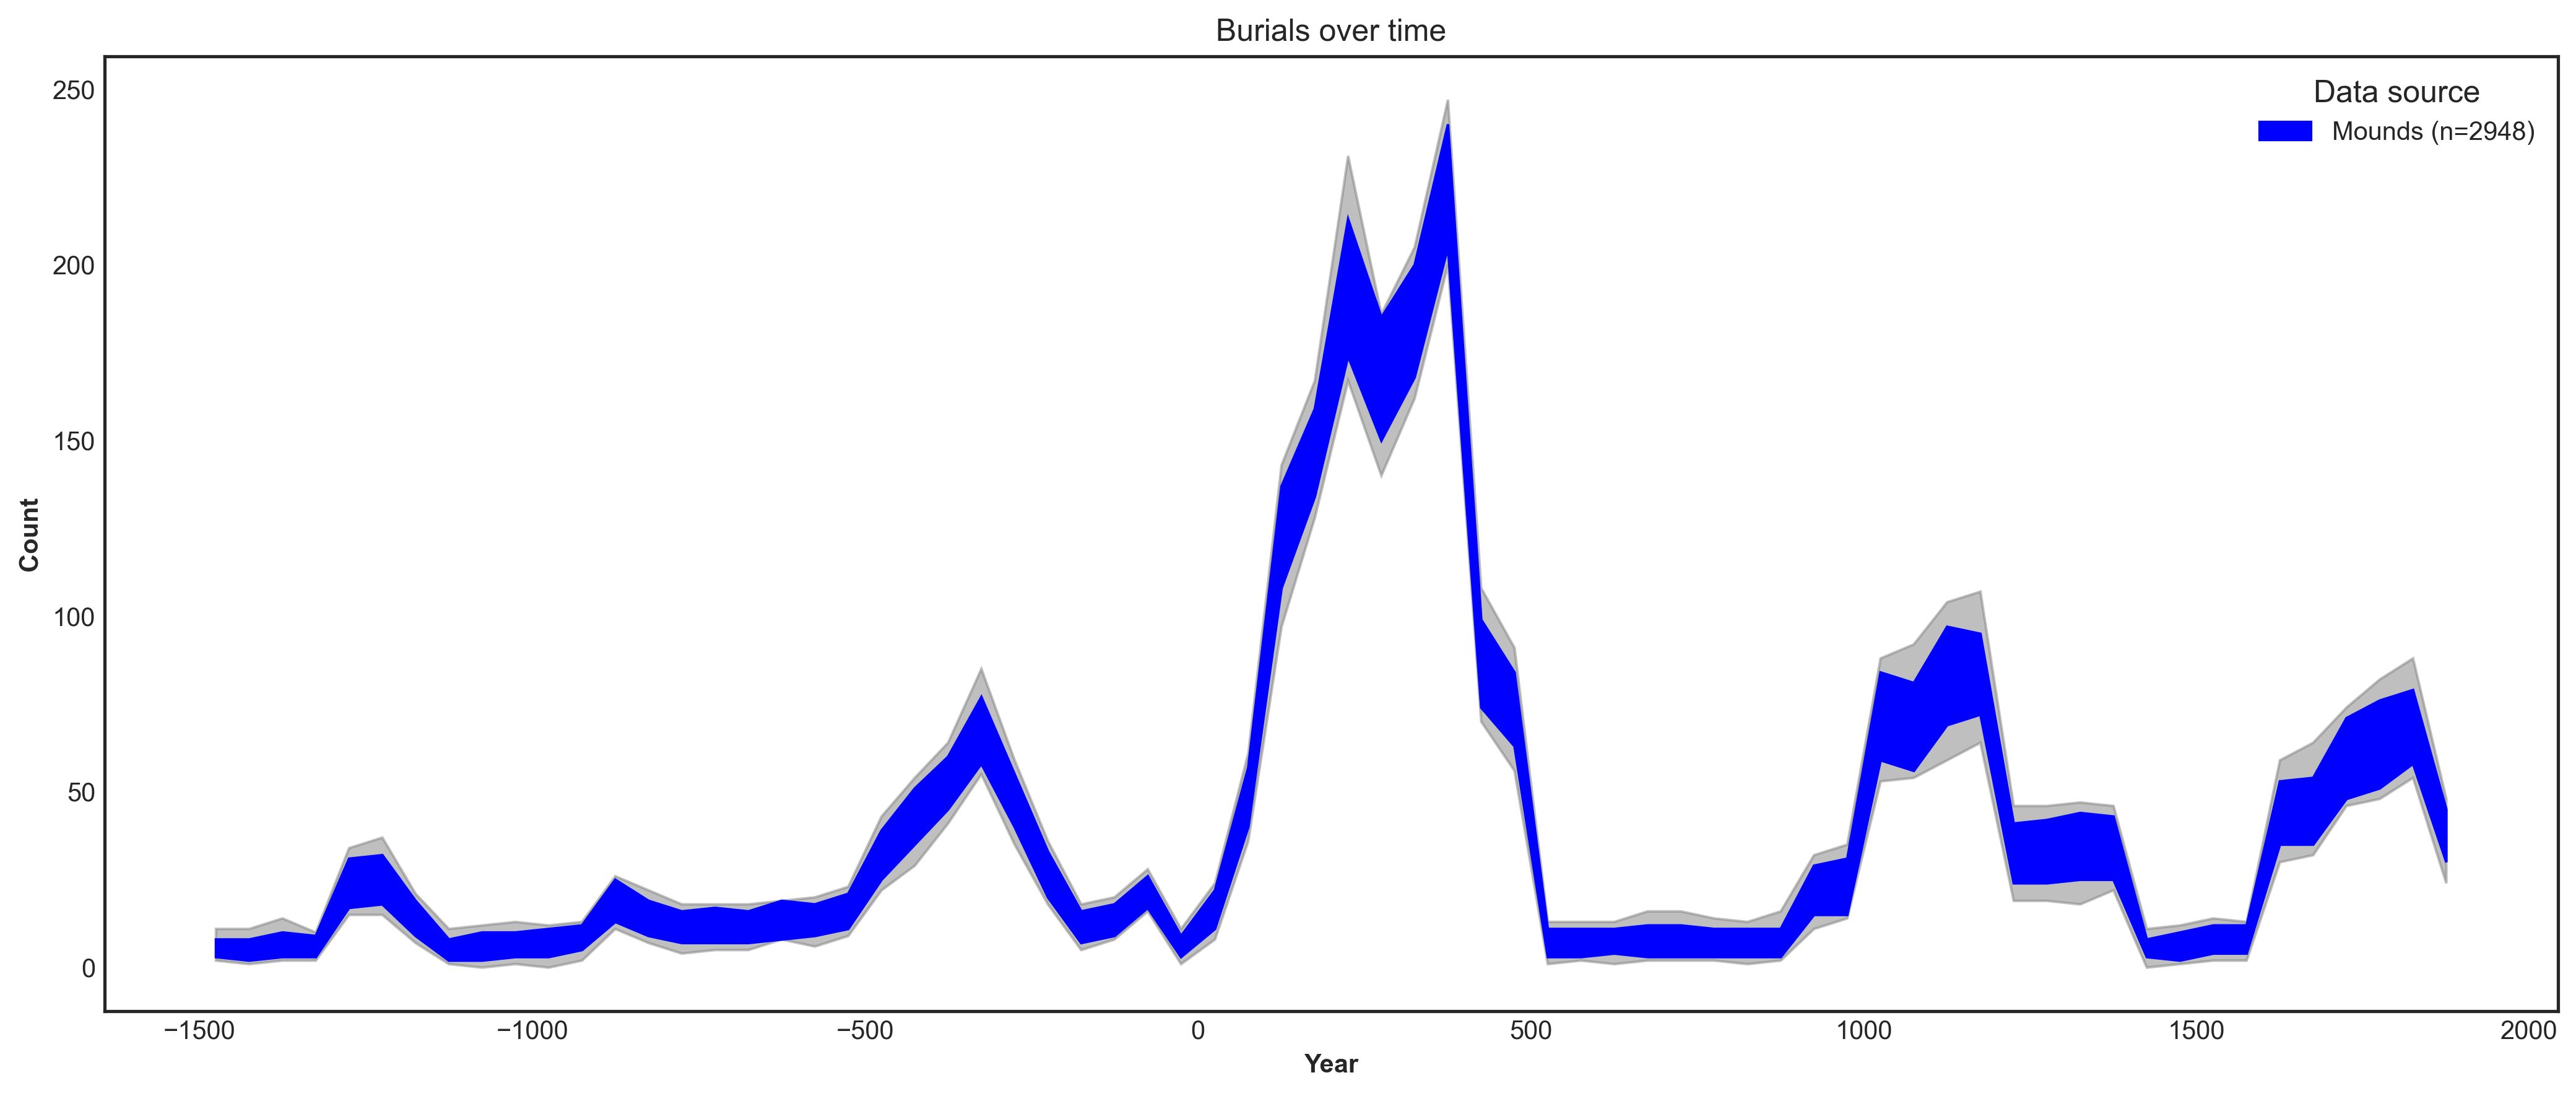

In [139]:
# Figure 1
# plot all the dataset to see the mounds over time

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)

tempun.plot_timeblocks_data(
   Mounds_complete_simulations, ax=ax, color="blue", label=f"Mounds (n={len(mounds_with_dates_df)})")
    
ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
ax.set_title("Burials over time")
ax.legend(title="Data source", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

#plt.axvline(x=212, linewidth=0.5, color = 'orange', linestyle='dashed')

#plt.savefig('../output/Fig1_Epi_production_time.png')

I will do a quick tempun analysis on the basis of the burials "Grave rank symbol":

I will start by dividing the data into the different grave rank symbols. I will start by creating a list, being only the numerical value of the grave rank, and a "n" if the burial isn't assigned any grave rank.

In [140]:
grave_rank_symbol_number = []
for index in Mounds_with_data_index:
    grave_rank_symbol_number.append(mounds_with_dates_df["Grave Rank symbols"][index][0])

In [141]:
mounds_with_dates_df["Grave rank symbol numbers"] = grave_rank_symbol_number

In [142]:
#I will start by completing simulation for each grave rank value:
Grave_rank_symbol_complete_simpulations = []
Grave_rank_symbols = list(set(mounds_with_dates_df["Grave rank symbol numbers"]))
for value in Grave_rank_symbols:
    value_df = mounds_with_dates_df[mounds_with_dates_df["Grave rank symbol numbers"] == value]
    value_complete_simulations = tempun.timeblocks_from_randoms(
    value_df, "random_dates", [-1500, 1900, 50], random_size=100)
    Grave_rank_symbol_complete_simpulations.append((value, value_complete_simulations))

Text(0.5, 1.0, 'Mounds by grave rank index')

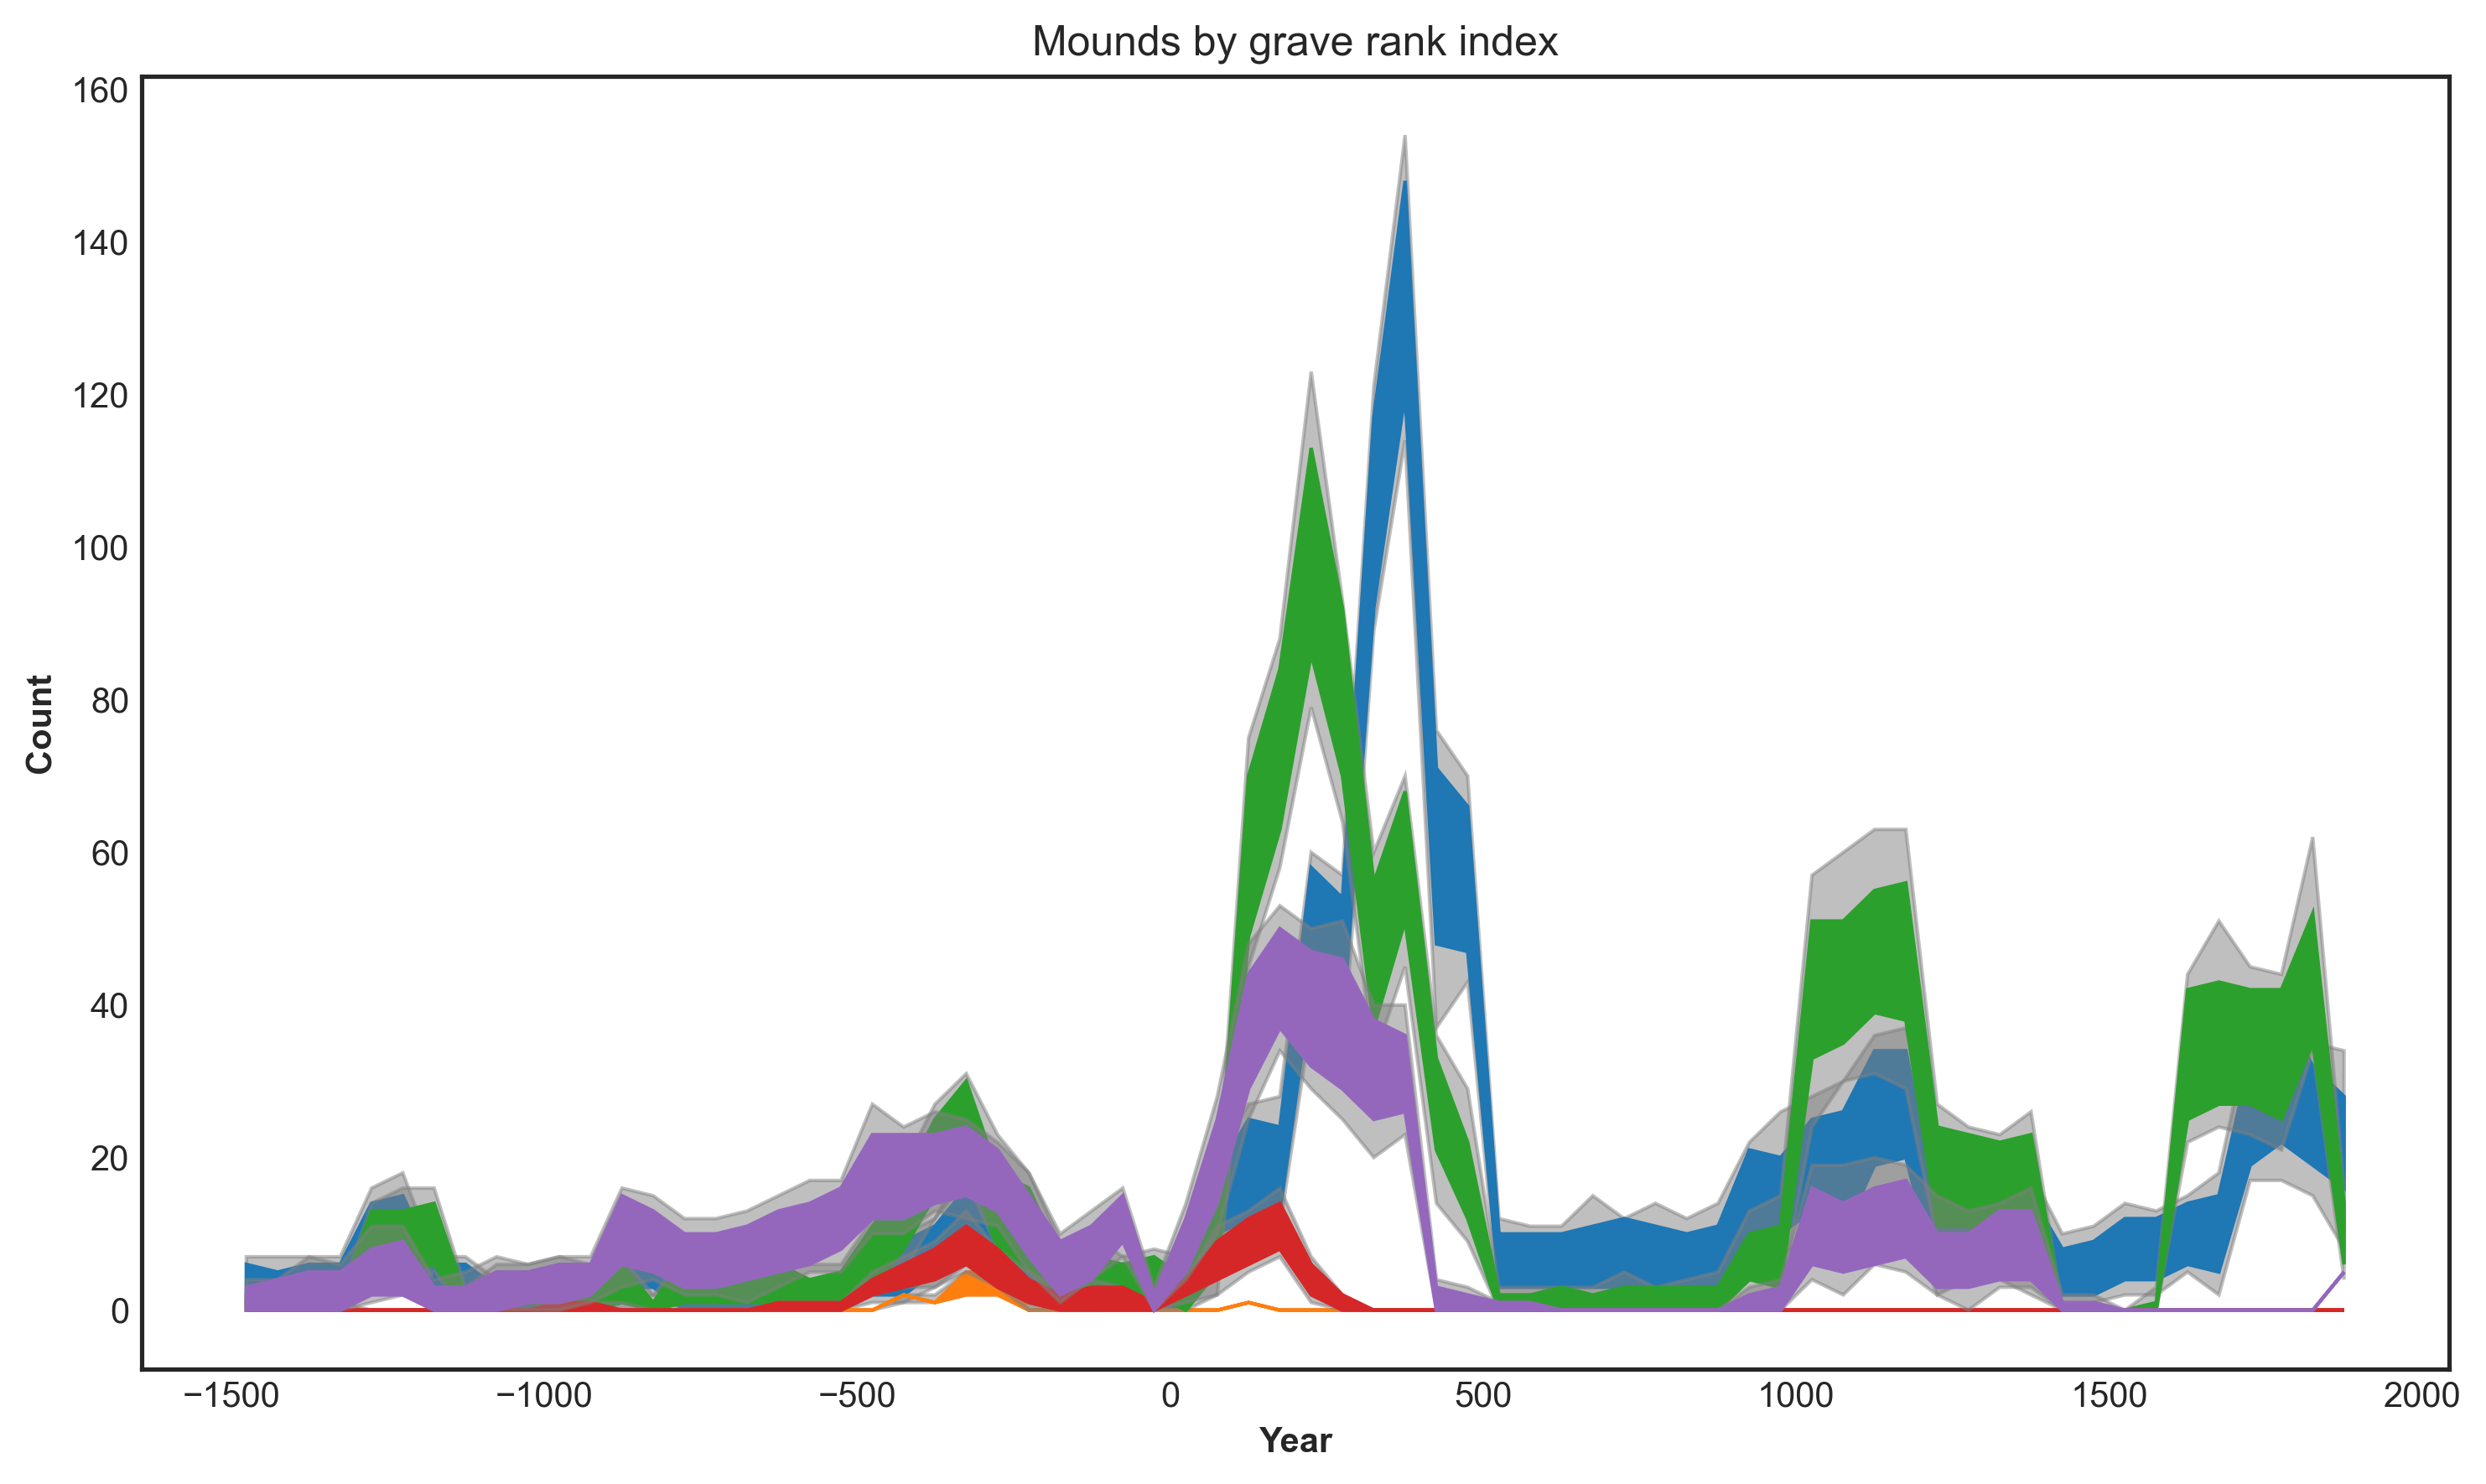

In [143]:
# I will now plot the tempun analysis by grave rank value

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)


for value, color in zip(Grave_rank_symbol_complete_simpulations, tab_colors_list[:len(Grave_rank_symbols)]):
    tempun.plot_timeblocks_data(
        value[1], ax=ax, color=color, 
            label=f"{value}")
    
ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
ax.set_title("Mounds by grave rank index")
#ax.legend()

## Joining the data in another dataframe

I slight problem with the moundsdata is that the data is storred in different sheets, i will quickly add this data to the dataframe.

Again there are two ways of loading the spacial data, either with the data locally on your computer, or from Google sheets.

In [144]:
#Running the data from the local source:

#mounds_Spatial = pd.read_excel(Mounds_all_sheets, "GeneralSpatial")

#getting the data from google sheets

sheet_instance_spacial = sheet.get_worksheet(0) #the spacial data is sheet number 0

mounds_spacial_data = sheet_instance_spacial.get_all_records()

mounds_Spatial = pd.DataFrame.from_dict(mounds_spacial_data)

In [145]:
List_of_moundID_and_data = [(mounds_Spatial["MoundID"][i], mounds_Spatial["Municipality"][i], 
                             mounds_Spatial["Region"][i], mounds_Spatial["Lat"][i]
                            , mounds_Spatial["Long"][i]) for i in range(len(mounds_Spatial))]
#I will now create a list where each burial in mounds_df gets assigned the spacial data.
Municipality = [0 for index in range(len(mounds_df))]
region = [0 for index in range(len(mounds_df))]
latitude = [0 for index in range(len(mounds_df))]
logitude = [0 for index in range(len(mounds_df))]
List_of_moundID_and_data

[(1107, 'Sliven', 'Sliven', 42.491623, 26.269778),
 (1179, 'Belitsa', 'Blagoevgrad', 41.935714, 23.573565),
 (1180, 'Belitsa', 'Blagoevgrad', 41.935714, 23.573565),
 (1391, 'Belitsa', 'Blagoevgrad', 41.920599, 23.571095),
 (1392, 'Belitsa', 'Blagoevgrad', 41.919751, 23.572341),
 (1393, 'Blagoevgrad', 'Blagoevgrad', 41.976922, 23.093051),
 (1012, 'Primorsko', 'Burgas', 42.277825, 27.726949),
 (1034, 'Malko Tarnovo', 'Burgas', 41.983169, 27.491924),
 (1035, 'Malko Tarnovo', 'Burgas', 41.983169, 27.491924),
 (1036, 'Malko Tarnovo', 'Burgas', 41.983169, 27.491924),
 (1060, 'Sungurlare', 'Burgas', 42.849954, 26.923644),
 (1110, 'Tsarevo', 'Burgas', 42.064993, 27.84797),
 (1114, 'Karnobat', 'Burgas', 42.560819, 26.8303),
 (1115, 'Karnobat', 'Burgas', 42.560717, 26.828433),
 (1128, 'Tsarevo', 'Burgas', 42.069266, 27.847132),
 (1129, 'Tsarevo', 'Burgas', 42.069266, 27.847132),
 (1144, 'Sredets', 'Burgas', 42.107539, 27.177713),
 (1149, 'Karnobat', 'Burgas', 42.642117, 26.84957),
 (1150, 'Karno

In [146]:
#I will now assign the data to the list:
List = []
for i in range(len(mounds_df)):
    mound_id = mounds_df["MoundID"][i]
    for mound in List_of_moundID_and_data:
        if mound[0] == mound_id:
            Municipality[i] = mound[1]
            region[i] = mound[2]
            latitude[i] = mound[3]
            logitude[i] = mound[4]

I now have lists containing the data i want to add to the mounds dataframe.

In [147]:
mounds_df.insert(3, "Municipality", Municipality, True)
mounds_df.insert(4, "Region", region, True)
mounds_df.insert(5, "Lat", latitude, True)
mounds_df.insert(6, "Long", logitude, True)
mounds_df.head()

,MoundID,Name,All periods,Municipality,Region,Lat,Long,Period,GraveNo,Enclosure Type,...,FineVessels,DrinkingCups,Jewellery,Weapons,SpecialFinds,Imports,Grave Rank symbols,StartDate,Enddate,Chronology rating
0,1002,Mound 5,"[Transitional period, Early Bronze Age]",Radnevo/ Beli Bryag,Stara Zagora,42.236726,25.957091,Transitional period,1,Simple pit,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
1,1002,Mound 5,"[Transitional period, Early Bronze Age]",Radnevo/ Beli Bryag,Stara Zagora,42.236726,25.957091,Transitional period,1,Simple pit,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
2,1002,Mound 5,"[Transitional period, Early Bronze Age]",Radnevo/ Beli Bryag,Stara Zagora,42.236726,25.957091,Transitional period,2,Simple pit,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
3,1002,Mound 5,"[Transitional period, Early Bronze Age]",Radnevo/ Beli Bryag,Stara Zagora,42.236726,25.957091,Transitional period,2,Simple pit,...,,,,,,,0 - No symbols of status present,-3500,-3000,1 - rough estimate by author on basis of the a...
4,1003,No name,"[Transitional period, Early Bronze Age]",Straldzha,Yambol,42.593881,26.750341,Transitional period,1,Simple pit,...,,,2(silver spirals),,red ochre,,"1 - One or two status symbols (ochre, personal...",-3500,-3000,3 - a number of burial aspects consulted and c...


Now that i have added the data to the dataframe, i will export the dataframe, and continue my analysis in R.

The first way is for saving the dataframe locally as an CSV-file. 

In [148]:
#mounds_df.to_csv('../data/Mounds_with_Spacial.csv', header=True, index=False)

If you want to upload the data directly to google sheets, this is what you need to do:

Go to your google-account and create an empty google-sheets, in this case mine was called "Mounds_with_spacial".
Then add your serviceaccount as a user to the empty sheet as you did before.

In [149]:
import pygsheets

In [150]:
gc = pygsheets.authorize(service_file="../../Keys/Google_sheets_access.json") #your service account

In [151]:
#open the google spreadsheet
sh = gc.open('Mounds_with_spacial') #the name of the empty sheet

#select the first sheet 
wks = sh[0]

#update the first sheet with df, starting at cell A1. 
wks.set_dataframe(mounds_df, (0,0))